In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectFromModel

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

import numpy as np

# Proyecto 1: Movistar

**Movistar está preocupada por el aterrizaje de Netflix y por la oferta de Vodafone. Teme que algunos de sus clientes que tienen contratado MovistarPlus se vean atraídos por la nueva oferta de Vodafone. Os plantea la realización del diseño de una campaña de incentivos para mantener el mayor número de clientes en su empresa. En concreto os piden:**

**1. Análisis de perfiles de posibles desertores. Os piden que determinéis un perfil del posible desertor. Y también un perfil para aquel que no lo sea. La empresa os proporciona un dataset con un histórico de clientes que han dejado la empresa y los que no. A partir de él tenéis que identificar el perfil o perfiles de los que han dejado la empresa para prever los que tienen una alta probabilidad de solicitar portabilidades a Vodafone. Los perfiles tienen que identificar los atributos relevantes y los valores para dichos atributos.**

In [2]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


Primero, veremos algunas estadísticas generales de nuestro dataset

In [3]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(f"Dimensiones del dataset: {df.shape}")

print(f"\nNulos en el dataset: {df.isna().sum().sum()}")
print("\nInformación general:")
display(df.info())

Dimensiones del dataset: (7043, 21)

Nulos en el dataset: 11

Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contra

None

Las entradas sin datos en TotalCharges tienen tenure 0, es decir 0 meses de permanencia, son clientes que acaban de registrarse por lo que factura total es 0

In [4]:
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [5]:
print("\nDistribución de clientes por deserción:")
churn_distribution = pd.concat([df['Churn'].value_counts(),
                                df['Churn'].value_counts(normalize=True).mul(100).round(2).astype(str)],
                                axis=1, keys=['Recuento', 'Porcentaje'])

display(churn_distribution)


Distribución de clientes por deserción:


,Recuento,Porcentaje
Churn,,
No,5174,73.46
Yes,1869,26.54


Aproximadamente un 25% de los clientes se cambian de compañía. A continuación, haremos un EDA de los datos para hacernos una idea *grosso modo* de que variables pueden ser las más decisivas para los clientes a la hora de permanecer en nuestra compañía o abandonarnos.

### Visualización inicial

Para hacer una análisis exploratorio sólido, dividiremos las columnas en tres grupos: demográficas (que referencian al cliente como persona), de servicio (que referencian a los servicios de los que el cliente es beneficiario). A su vez, para hacer representaciones adecuadas de los datos debemos discernir entre variables categóricas y numéricas. Primero, veremos las variables categóricas:

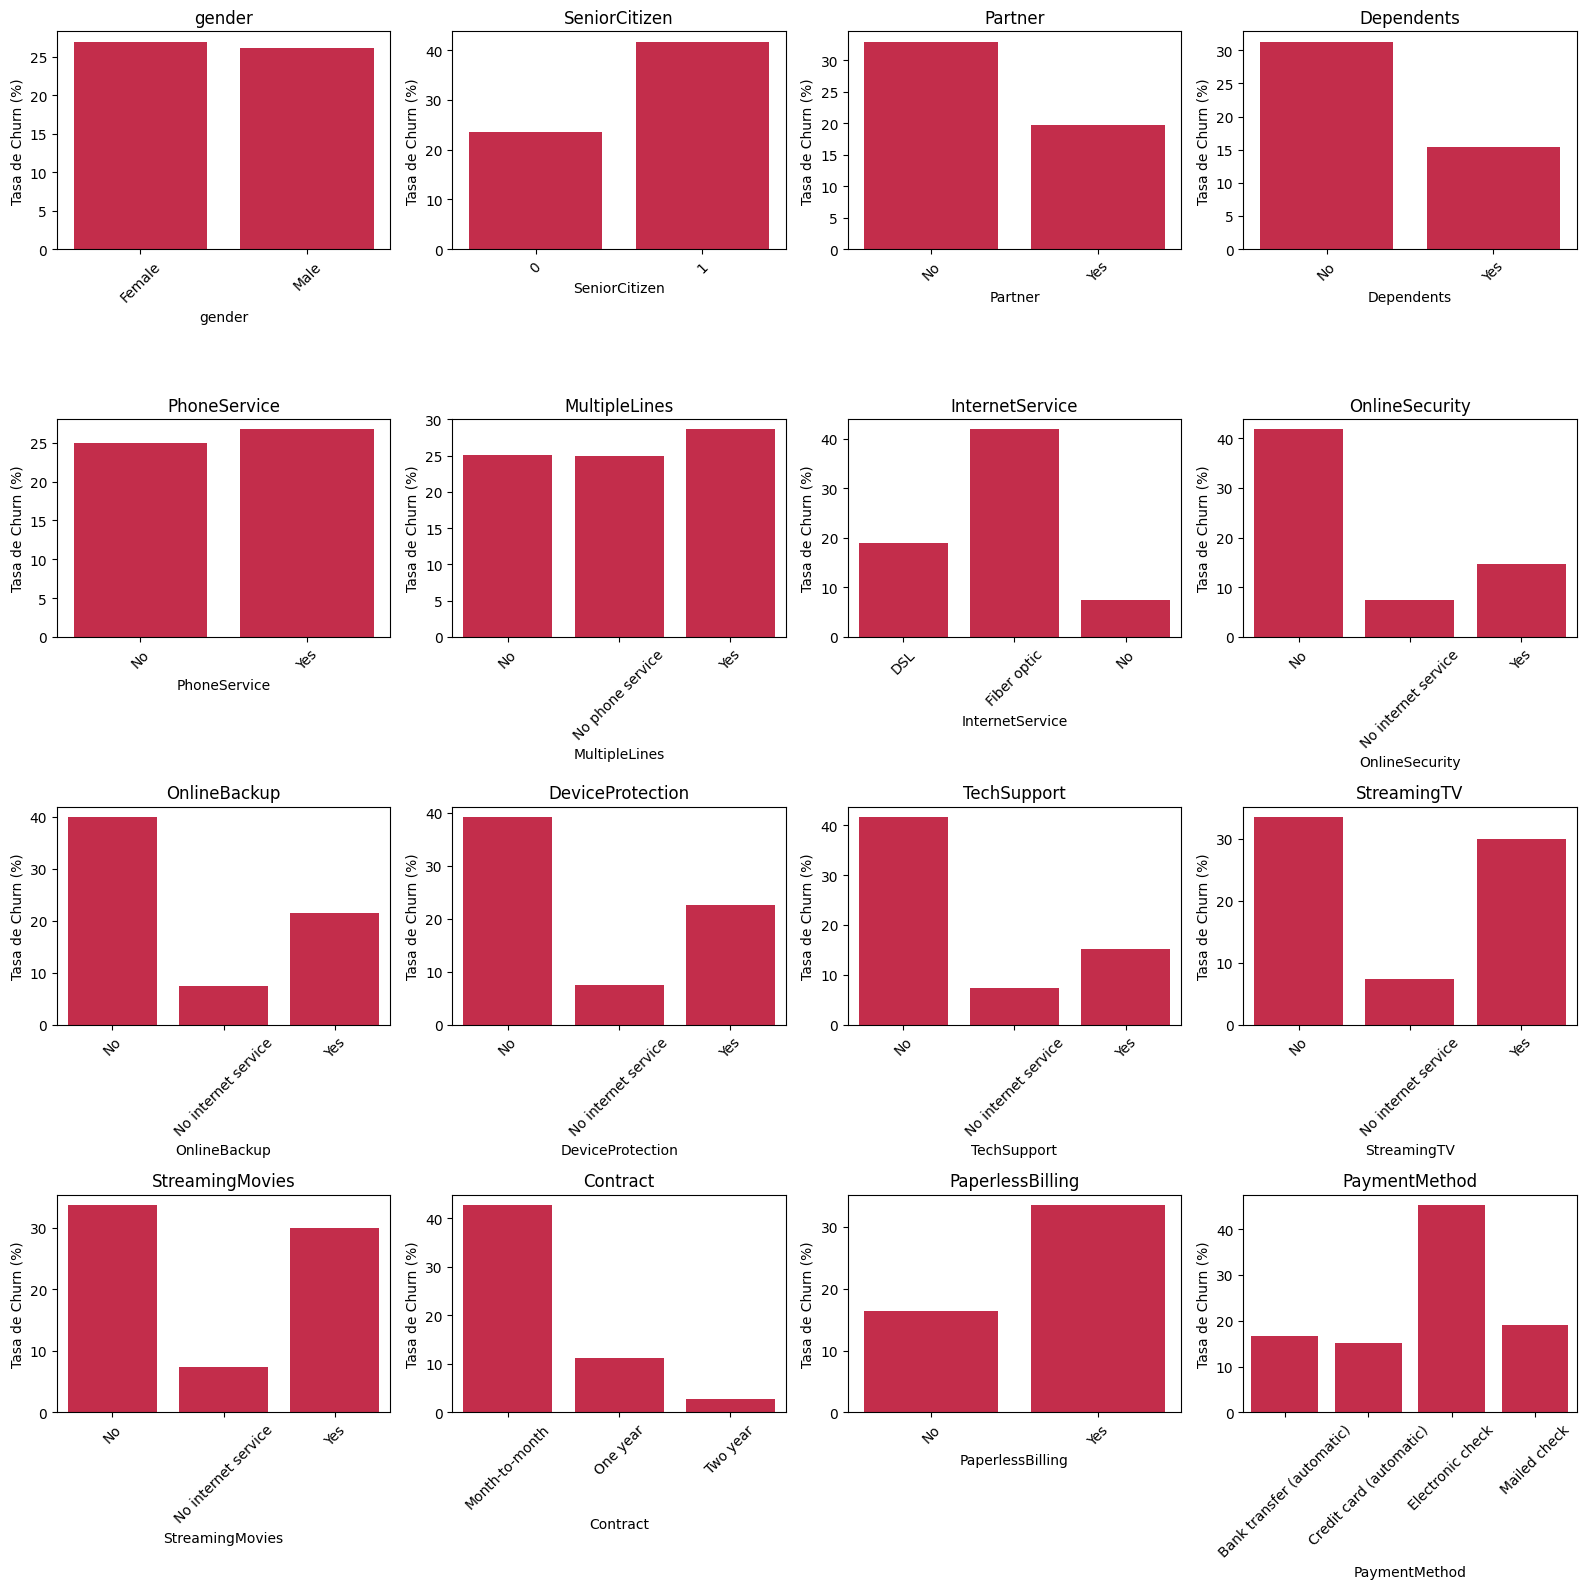

In [6]:
demographic_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

categorical_cols = demographic_cols + service_cols + ['Contract', 'PaperlessBilling', 'PaymentMethod']

fig_cat, axes_cat = plt.subplots(4, 4, figsize=(16, 16))
axes_flat = axes_cat.flatten()

for i, feature in enumerate(categorical_cols):
    ax = axes_flat[i]
    churn_rate = pd.crosstab(df[feature], df['Churn'], normalize='index') * 100
    sns.barplot(x=churn_rate.index, y=churn_rate['Yes'], ax=ax, color='crimson')
    ax.set_title(feature)
    ax.set_ylabel('Tasa de Churn (%)')
    ax.tick_params(axis='x', rotation=45)

for j in range(len(categorical_cols), len(axes_flat)):
    axes_flat[j].axis('off')

plt.tight_layout()
plt.show()

BLABLABLABLABL

A continuación, visualizamos las variables numéricas, junto a su distribución de valores.

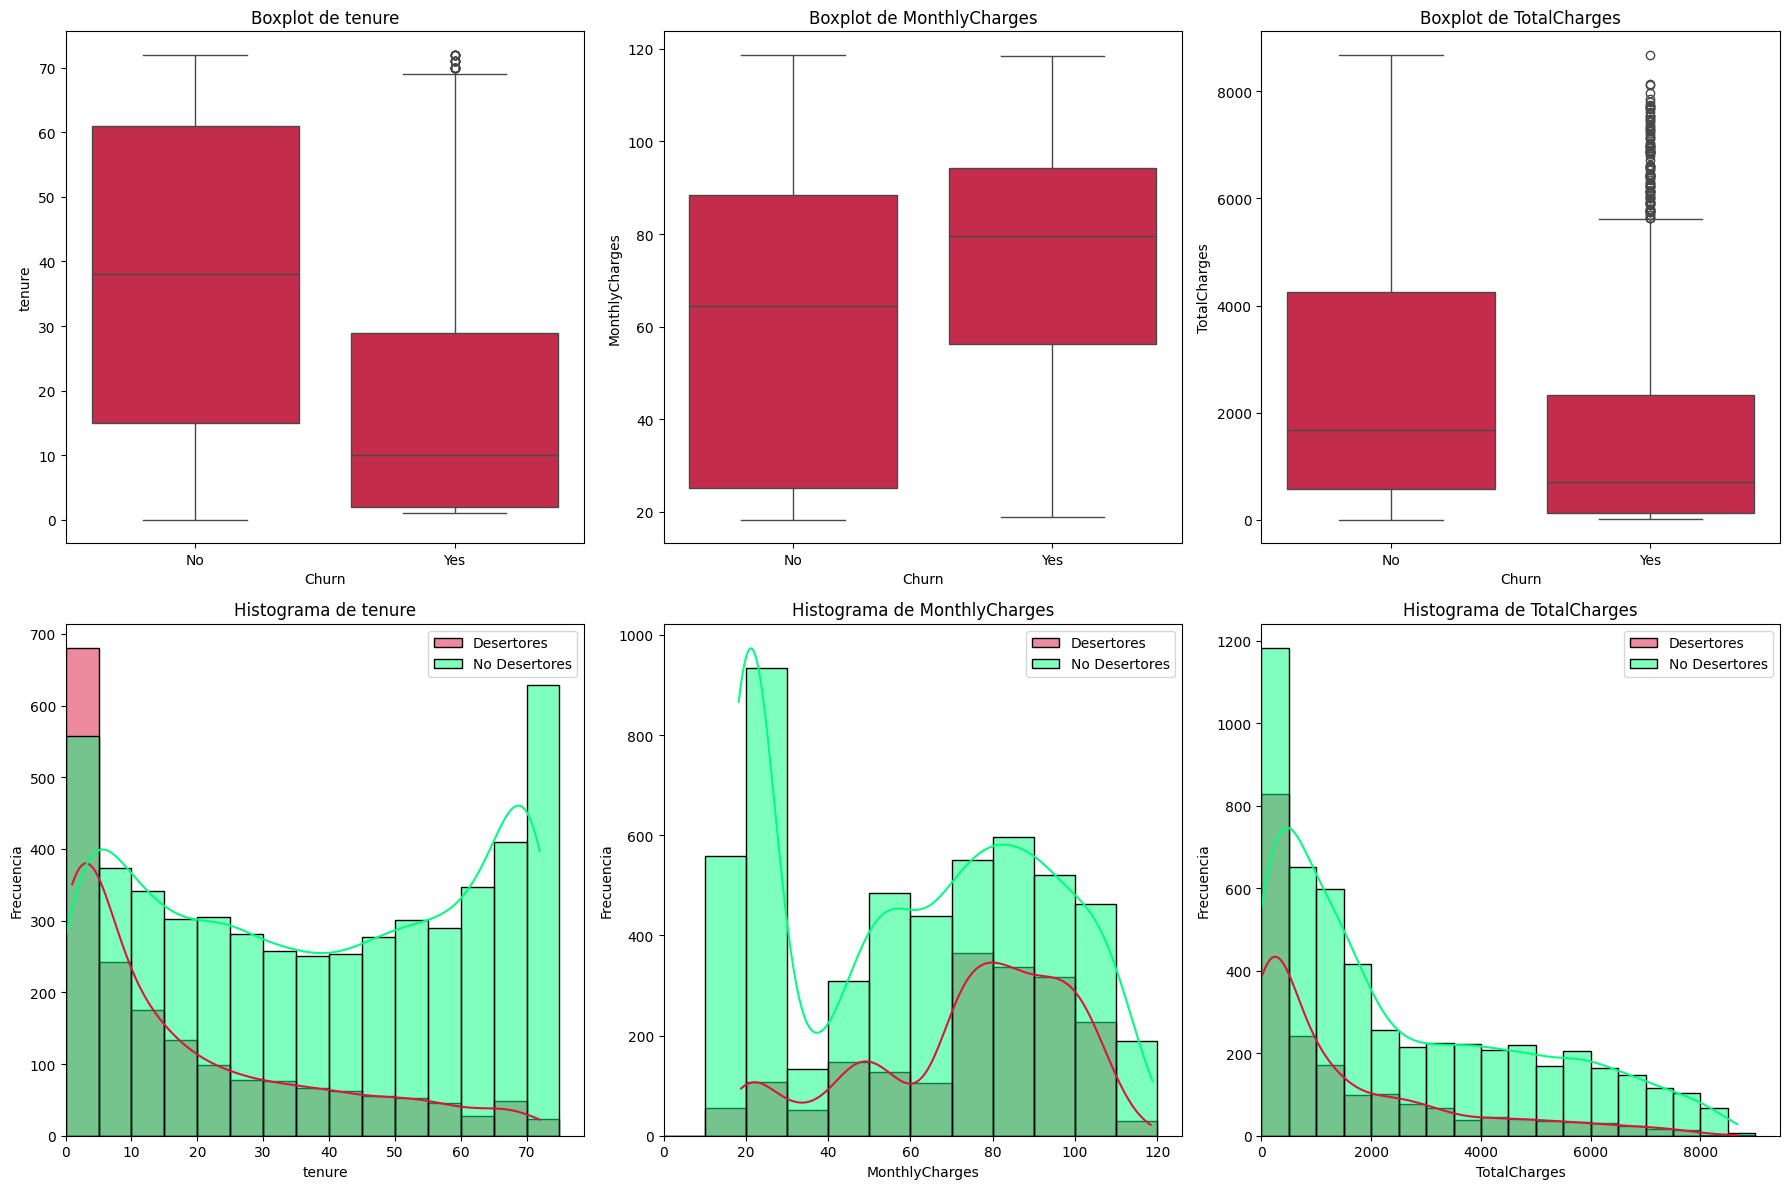

In [7]:
bin_widths = {'tenure': 5, 'MonthlyCharges': 10, 'TotalCharges': 500}
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

fig_num, axes_num = plt.subplots(2, 3, figsize=(18, 12))

for i, feature in enumerate(numerical_cols):
    ax_box = axes_num[0, i]
    ax_hist = axes_num[1, i]

    sns.boxplot(x='Churn', y=feature, data=df, ax=ax_box, color='crimson')
    ax_box.set_title(f'Boxplot de {feature}')

    bins = range(0, int(df[feature].max()) + bin_widths[feature], bin_widths[feature])
    sns.histplot(df[df['Churn'] == 'Yes'][feature], color='crimson', kde=True,
                 label='Desertores', ax=ax_hist, bins=bins)

    sns.histplot(df[df['Churn'] == 'No'][feature], color='springgreen', kde=True,
                 label='No Desertores', ax=ax_hist, bins=bins)

    ax_hist.legend()
    ax_hist.set_title(f'Histograma de {feature}')
    ax_hist.set_xlim(left=0)
    ax_hist.set_xlabel(feature)
    ax_hist.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

BLABLABLABLABLABLAALBALABL

### Reglas de asociación

### Selección de características

Heremos una selección de características usando métodos de aprendizaje supervisado con el fin de determinar el perfil de posibles (y no posibles) desertores.

Lo primero, es darle el formato adecuado al dataframe para que pueda nusarlo modelos de supervisados. Para ello:
1. Eliminamos los nulos.
2. Codificamos la deserción `Churn` como `Yes`$\rightarrow$1, `No`$\rightarrow$`0`.
3. Codificamos las variables categóricas.
4. Eliminamos la columna `customerID`.

In [8]:
def pretty_data(df):
    data = df.copy()
    data_clean = data.dropna()

    if len(data_clean) < len(data):
        print(f"Eliminamos {len(data) - len(data_clean)} filas con valores nulos")

    data_clean['Churn_Encoded'] = data_clean['Churn'].map({'Yes': 1, 'No': 0})

    le = LabelEncoder()
    categorical_cols = []

    for col in data_clean.columns:
        if data_clean[col].dtype == 'object' and col != 'customerID':
            data_clean[col] = le.fit_transform(data_clean[col])
            categorical_cols.append(col)

    if 'customerID' in data_clean.columns:
        data_clean = data_clean.drop('customerID', axis=1)

    return data_clean, categorical_cols

Aplicamos la función para adecuar el formato de los datos a modelos de machine learning. Como predictores usamos en principio todas las características, quitando las columnas de deserción y deserción en forma categórica.

Dividimos el conjunto total de datos en conjuntos de *train* y *test* estratificados y los estandarizamos con un StandardScaler, es decir, llevamos las distribuciones de las variables a unas con media 0 y desviación estándar unitaria.

In [9]:
processed_data, categorical_cols = pretty_data(df)

X = processed_data.drop(['Churn', 'Churn_Encoded'], axis=1)
y = processed_data['Churn_Encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Dimensiones de X_train: (5282, 19)
Dimensiones de X_test: (1761, 19)


Usaremos varios modelos con una interpretabilidad relativamente alta para obtener resultados robustos. Definimos así los modelos:
- Regresión logística con penalización ElasticNet ($L1 + L2$): nos da un equilibrio entre selección ($L1$) y estabilidad ($L2$).
- Regresión logística con penalización $L1$, para una selección automática.
- Random Forest: nos permite buscar patrones no lineales y obtener la importancia de las características.
- ExtraTrees: como un Random Forest, pero una mayor aleatoriedad, lo que nos permite mantener una varianza baja en todo el conjunto.
- Linear SVM: lo introducimos como modelo robusto ante *outliers*.
- XGBoost: el modelo menos interpretable de los considerados. No obstante, al ser de distinta naturaleza, nos da un enfoque complementario.

In [10]:
models = {
    'ElasticNetLR': LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        l1_ratio=0.5,
        C=10.0,
        max_iter=10000,
        random_state=42
    ),
    'Logistic L1': LogisticRegression(
        penalty='l1',
        solver='saga',
        C=1.0,
        max_iter=10000,
        random_state=42
    ),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Linear SVM': SVC(kernel='linear', probability=True, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, learning_rate=0.1)
}

Ahora, entrenamos estos modelos con el conjunto de *train* y nos basamos en las predicciones sobre el conjunto de *test* para

In [15]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

def compute_shap_feature_importance(models,
                                    X_train, X_test,
                                    y_train, y_test,
                                    feature_names=None):
    """
    Calcula importancia de features usando SHAP values para cada modelo,
    construye un ranking por avg_rank y pinta un barplot normalizado
    del top-10.

    Parámetros
    ----------
    models : dict
        Diccionario {'nombre_modelo': instancia_modelo}
    X_train, X_test : pandas.DataFrame o array
    y_train, y_test : array-like
    feature_names : list de str, opcional
        Si X_train es DataFrame, por defecto usa X_train.columns.

    Retorna
    -------
    imp_df : pandas.DataFrame
        DataFrame con columnas por modelo y avg_rank.
    aucs : dict
        AUC de cada modelo en X_test.
    """
    if feature_names is None:
        if hasattr(X_train, "columns"):
            feature_names = X_train.columns
        else:
            raise ValueError(
                "X_train es array; pasa feature_names=list(columnas)."
            )

    imps = {}
    aucs = {}

    for name, mod in models.items():
        # 1) Entrenar
        mod.fit(X_train, y_train)

        # 2) Calcular AUC
        if hasattr(mod, "predict_proba"):
            scores = mod.predict_proba(X_test)[:, 1]
        elif hasattr(mod, "decision_function"):
            scores = mod.decision_function(X_test)
        else:
            scores = mod.predict(X_test)
        aucs[name] = roc_auc_score(y_test, scores)

        # 3) SHAP explainer
        # Para modelos de árbol usamos TreeExplainer (rápido)
        if hasattr(mod, "feature_importances_") or "XGBoost" in name:
            explainer = shap.TreeExplainer(mod)
            shap_vals = explainer.shap_values(X_test)
            # en clasificación binaria TreeExplainer devuelve lista [neg, pos]
            if isinstance(shap_vals, list):
                shap_vals = shap_vals[1]
        else:
            # Regresión logística, SVM lineal...
            explainer = shap.LinearExplainer(
                mod, X_train, feature_perturbation="interventional"
            )
            shap_vals = explainer.shap_values(X_test)

        # 4) Mean absolute SHAP por feature
        imp = np.abs(shap_vals).mean(axis=0)
        imps[name] = imp

    # 5) DataFrame y avg_rank
    imp_df = pd.DataFrame(imps, index=feature_names)
    ranks = imp_df.rank(ascending=False)
    imp_df["avg_rank"] = ranks.mean(axis=1)
    imp_df.sort_values("avg_rank", inplace=True)

    # 6) Mostrar resultados
    print("AUC por modelo:", aucs)
    print("\nTop 10 características según avg_rank:\n",
          imp_df[["avg_rank"] + list(imps.keys())].head(10))

    # 7) Preparar gráfico del top-10
    top10 = imp_df.head(10).index
    temp = imp_df.loc[top10, list(imps.keys())]
    # normalizar por el máximo de cada columna
    norm = temp.divide(temp.max()).fillna(0)
    plot_df = norm.reset_index().melt(
        id_vars="index", var_name="model", value_name="importance"
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=plot_df,
        x="importance", y="index", hue="model",
        palette="viridis"
    )
    plt.title("Top 10 features (SHAP) normalizadas por modelo")
    plt.xlabel("Importancia normalizada (mean |SHAP|)")
    plt.ylabel("Feature")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    return imp_df, aucs

imp_df, aucs = compute_shap_feature_importance(models, X_train_scaled, X_test_scaled, 
                                               y_train, y_test, feature_names=X_train.columns)


/Users/luisi/Documents/Master-Big-Data/Aplicaciones y casos de uso empresarial/.venv/lib/python3.11/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
/Users/luisi/Documents/Master-Big-Data/Aplicaciones y casos de uso empresarial/.venv/lib/python3.11/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
/Users/luisi/Documents/Master-Big-Data/Aplicaciones y casos de uso empresarial/.venv/lib/python3.11/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Im

ValueError: Data must be 1-dimensional, got ndarray of shape (19, 2) instead

AUC por modelo: {'ElasticNetLR': np.float64(0.8430826993402796), 'Logistic L1': np.float64(0.8429425776871198), 'ExtraTrees': np.float64(0.793288402521271), 'RandomForest': np.float64(0.8163579396144588), 'XGBoost': np.float64(0.8310954067662678), 'Linear SVM': np.float64(0.8372906214969587)}

Top 10 features:
                   avg_rank  ElasticNetLR  Logistic L1  ExtraTrees  \
tenure            2.500000      1.361979     1.309558    0.142919   
TotalCharges      3.166667      0.672292     0.616695    0.145727   
MonthlyCharges    3.333333      0.672950     0.678496    0.127933   
Contract          4.166667      0.604215     0.602542    0.084753   
OnlineSecurity    5.666667      0.243574     0.242369    0.047151   
TechSupport       6.333333      0.226286     0.225297    0.047102   
InternetService   8.000000      0.118482     0.114630    0.037832   
PaperlessBilling  8.833333      0.214984     0.213756    0.031896   
PaymentMethod     9.500000      0.098108     0.097259    0.065260 

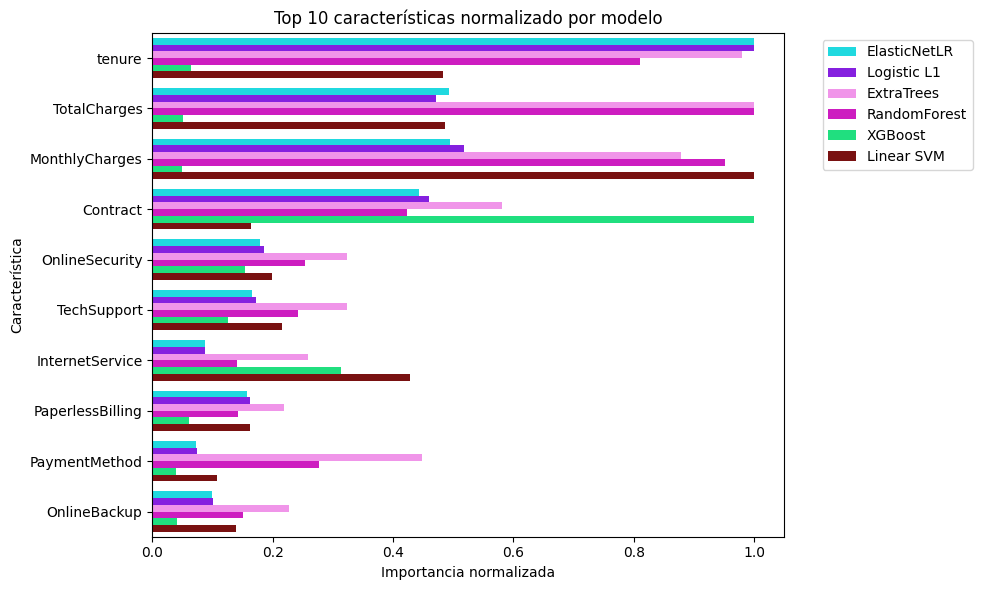

In [ ]:
def compute_feature_importance(models, X_train, X_test, y_train, y_test, feature_names=None):
    if feature_names is None:
        if hasattr(X_train, 'columns'):
            feature_names = X_train.columns

        else:
            raise ValueError("X_train es array; debes pasar feature_names=list(columnas).")

    imps, aucs = {}, {}
    for name, mod in models.items():
        mod.fit(X_train, y_train)

        if hasattr(mod, 'coef_'):
            imp = np.abs(mod.coef_[0])

        elif hasattr(mod, 'feature_importances_'):
            imp = mod.feature_importances_

        else:
            print(f"Cuidao con {name}: sin coef_ ni feature_importances_; salto.")
            continue

        imps[name] = imp

        if hasattr(mod, 'predict_proba'):
            scores = mod.predict_proba(X_test)[:, 1]

        elif hasattr(mod, 'decision_function'):
            scores = mod.decision_function(X_test)

        else:
            scores = mod.predict(X_test)

        aucs[name] = roc_auc_score(y_test, scores)

    imp_df = pd.DataFrame(imps, index=feature_names)
    ranks = imp_df.rank(ascending=False)
    imp_df['avg_rank'] = ranks.mean(axis=1)
    imp_df.sort_values('avg_rank', inplace=True)

    print("AUC por modelo:", aucs)
    print("\nTop 10 features:\n", imp_df[['avg_rank'] + list(imps.keys())].head(10))

    top10 = imp_df.head(10).index
    temp = imp_df.loc[top10, list(imps.keys())]
    norm = temp.divide(temp.max().replace(0, np.nan)).fillna(0)
    plot_df = norm.reset_index().melt(id_vars='index', var_name='model', value_name='importance')

    colorcitos = ['#00f7ff', '#8700FF', '#FF86F6', '#EA00D9', 'springgreen', '#8A0000']

    plt.figure(figsize=(10, 6))
    sns.barplot(data=plot_df, x='importance', y='index', hue='model', palette=colorcitos)
    plt.title('Top 10 características normalizado por modelo')
    plt.xlabel('Importancia normalizada')
    plt.ylabel('Característica')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return imp_df

imp_df = compute_feature_importance(models, X_train_scaled, X_test_scaled, y_train, y_test, feature_names=X_train.columns)

**Perfil del posible desertor:** Cliente reciente, con contrato mensual, factura elevada, sin servicios añadidos de seguridad o soporte técnico, factura electrónica, y que utiliza fibra óptica. Es el perfil más común de deserción.

- **Contract**: Month-to-month --> Tasa de deserción muy alta (42.71%)
- **OnlineSecurity / TechSupport / OnlineBackup**: No --> Tasa de deserción muy alta (alrededor del 40%)
- **PaperlessBilling**: Yes (Tasa de deserción del 33.57%)
- **InternetService**: Fiber optic --> Tasa de deserción muy alta (41.89%)
- **Tenure** (meses de permanencia): Baja (18 de media y el 75% tienen 29 o menos meses de permanencia)
- **TotalCharges** (factura total): No muy alta (1532 de media)
- **MonthlyCharges** (factura mensual): Mas alta (74 de media)

**Perfil del que no es posible desertor**: Cliente con contrato de largo plazo, con servicios añadidos, menor facturación mensual, sin facturación electrónica ni servicio de internet, y que lleva mucho tiempo en la empresa. Son clientes más tradicionales y menos propensos al cambio.
- **Contract**: Two Year --> Tasa de deserción muy baja (2.83%)
- **OnlineSecurity / TechSupport / OnlineBackup**: Yes o No internet service
- **PaperlessBilling**: No
- **InternetService**: DSL o No Internet
- **Tenure** (meses de permanencia): Alta (38 de media y mediana)
- **TotalCharges** (factura total): Alta (2550 de media)
- **MonthlyCharges** (factura mensual): Menor (62 de media)

2. Segmentación/creación de grupos entre los desertores y los no desertores. Os piden
también agrupar los usuarios dentro de cada clase en función de sus atributos más
relevantes. Esta segmentación será clave para diseñar la campaña de incentivos.

In [ ]:
#Seleccionamos las variables más relevantes
top_features = imp_df.head(10).index.tolist()

df_cluster = df.copy()
df_cluster = pd.get_dummies(df_cluster[top_features])

# Añadimos columna Churn para separar
df_cluster['Churn'] = df['Churn']

# Separamos en desertores y no desertores
desertores = df_cluster[df_cluster['Churn'] == 'Yes'].drop('Churn', axis=1)
no_desertores = df_cluster[df_cluster['Churn'] == 'Yes'].drop('Churn', axis=1)

# Escalamos
scaler = StandardScaler()
X_desertores = scaler.fit_transform(desertores)
X_no_desertores = scaler.fit_transform(no_desertores)

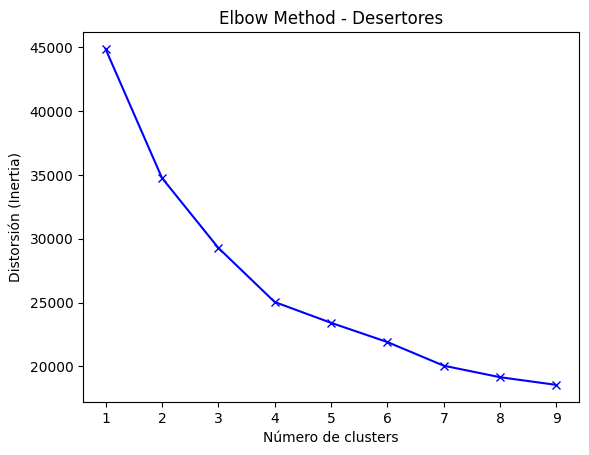

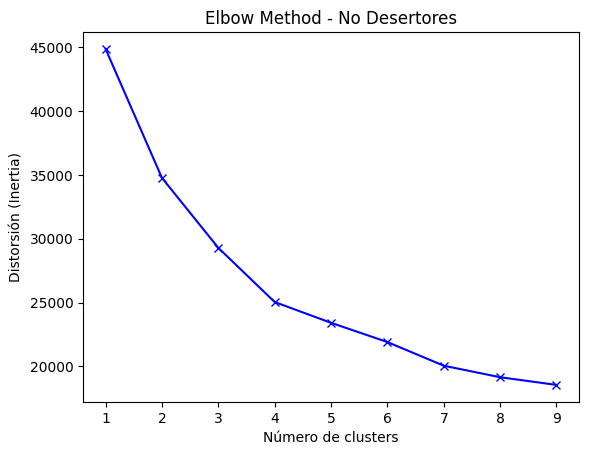

In [ ]:
# Encontramos el numero optimo de clusters. Usamos el metodo del codo
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def plot_elbow(X, title):
    distortions = []
    K = range(1, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)

    plt.figure()
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Número de clusters')
    plt.ylabel('Distorsión (Inertia)')
    plt.title(f'Elbow Method - {title}')
    plt.show()

plot_elbow(X_desertores, 'Desertores')
plot_elbow(X_no_desertores, 'No Desertores')

In [ ]:
# Aplicamos KMeans con número óptimo de clusters
# El codo se da entre 3 y 5 clústers (seleccionamos 5 clusters)
kmeans_desertores = KMeans(n_clusters=5, random_state=42)
desertores['Cluster'] = kmeans_desertores.fit_predict(X_desertores)

kmeans_no_desertores = KMeans(n_clusters=5, random_state=42)
no_desertores['Cluster'] = kmeans_no_desertores.fit_predict(X_no_desertores)


In [ ]:
# Análisis de clusters

# Mostrar todas las columnas
pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')

print("\n--- Desertores ---")
desertores.groupby('Cluster').mean()


--- Desertores ---


,tenure,MonthlyCharges,TotalCharges,Contract_Month-to-month,Contract_One year,Contract_Two year,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,PaperlessBilling_No,PaperlessBilling_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,PhoneService_No,PhoneService_Yes
Cluster,,,,,,,,,,,,,,,,,,,,,,
0,7.769231,53.207692,442.884413,0.975709,0.024291,0.000000,0.765182,0.0,0.234818,0.785425,0.0,0.214575,0.404858,0.595142,1.000000,0.000000,0.0,0.829960,0.0,0.170040,0.0,1.0
1,15.877285,86.231810,1445.147563,1.000000,0.000000,0.000000,0.894691,0.0,0.105309,0.896432,0.0,0.103568,0.171453,0.828547,0.000000,1.000000,0.0,0.730200,0.0,0.269800,0.0,1.0
2,15.835294,37.533824,687.087941,0.900000,0.082353,0.017647,0.829412,0.0,0.170588,0.835294,0.0,0.164706,0.305882,0.694118,1.000000,0.000000,0.0,0.700000,0.0,0.300000,1.0,0.0
3,8.238938,20.368142,173.919912,0.876106,0.079646,0.044248,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.628319,0.371681,0.000000,0.000000,1.0,0.000000,1.0,0.000000,0.0,1.0
4,51.673684,95.925526,5034.747368,0.068421,0.721053,0.210526,0.542105,0.0,0.457895,0.421053,0.0,0.578947,0.257895,0.742105,0.221053,0.778947,0.0,0.368421,0.0,0.631579,0.0,1.0


In [ ]:
print("\n--- No Desertores ---")
no_desertores.groupby('Cluster').mean()


--- No Desertores ---


,tenure,MonthlyCharges,TotalCharges,Contract_Month-to-month,Contract_One year,Contract_Two year,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,PaperlessBilling_No,PaperlessBilling_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,PhoneService_No,PhoneService_Yes
Cluster,,,,,,,,,,,,,,,,,,,,,,
0,7.769231,53.207692,442.884413,0.975709,0.024291,0.000000,0.765182,0.0,0.234818,0.785425,0.0,0.214575,0.404858,0.595142,1.000000,0.000000,0.0,0.829960,0.0,0.170040,0.0,1.0
1,15.877285,86.231810,1445.147563,1.000000,0.000000,0.000000,0.894691,0.0,0.105309,0.896432,0.0,0.103568,0.171453,0.828547,0.000000,1.000000,0.0,0.730200,0.0,0.269800,0.0,1.0
2,15.835294,37.533824,687.087941,0.900000,0.082353,0.017647,0.829412,0.0,0.170588,0.835294,0.0,0.164706,0.305882,0.694118,1.000000,0.000000,0.0,0.700000,0.0,0.300000,1.0,0.0
3,8.238938,20.368142,173.919912,0.876106,0.079646,0.044248,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.628319,0.371681,0.000000,0.000000,1.0,0.000000,1.0,0.000000,0.0,1.0
4,51.673684,95.925526,5034.747368,0.068421,0.721053,0.210526,0.542105,0.0,0.457895,0.421053,0.0,0.578947,0.257895,0.742105,0.221053,0.778947,0.0,0.368421,0.0,0.631579,0.0,1.0


Podemos dividir los desertores y no desertores en grupos. Por un lado vamos a dividir los **desertores**:


- **Grupo 0: Clientes con DSL y servicios básicos**: Usuarios con contrato mensual, baja permanencia, usan Internet DSL y pocos servicios digitales extra.
  - **Permanendia muy baja**: tenure 7.8 meses de media
  - **Facturacion mensual media**: MonthlyCharges 53.2 de media
  - **Facturación total baja**: 442.9 de media
  - **Internet: DSL**
  - **Muy baja contratacion de servicios digitales**: OnlineSecurity / TechSupport / OnlineBackup --> No (80%), Yes (20%)
  - **Contrato mes a mes** (en el 97.6% de los casos)
  - **Télefono**: Sí (100%)


- **Grupo 1: Clientes con fibra óptica y alta facturación**: Clientes con contrato mensual, Internet de alta velocidad (fibra óptica), uso moderado de servicios y alta facturación.
  - **Permanendia baja**: tenure 15.9 meses de media
  - **Facturacion mensual alta**: MonthlyCharges 86.2 de media
  - **Factura total media-alta**: 1445 de media
  - **Internet: fibra óptica**
  - **Pocos servicios digitales**: OnlineSecurity / TechSupport / OnlineBackup --> No (70%), Yes (30%)
  - **Contratos mes a mes** (100%)
  - **Télefono**: Sí (100%)
  - **Facturación en papel: Sí** (100%)

- **Grupo 2: Clientes con DSL y sin teléfono**: Usuarios con Internet DSL, sin servicio telefónico, permanencia moderada y bajo gasto mensual.
  - **Permanendia baja**: tenure 15.8 meses de media
  - **Facturacion mensual baja**: MonthlyCharges 37.5 de media
  - **Facturacion total baja**: 687 de media
  - **Internet: DSL**
  - **Muy baja contratacion de servicios digitales**: OnlineSecurity / TechSupport / OnlineBackup --> No (80%), Yes (20%)
  - **Contratos mes a mes** (90%)
  - **Télefono**: No (100%)
  - **Facturación sin papel: Sí** (69.4%)

- **Grupo 3: Clientes con servicios mínimos y baja permanencia**: Sin Internet, sin servicios adicionales, contrato mensual, muy baja facturación. Poco rentable y difícil de fidelizar.
  - **Permanencia muy baja**: tenure 8.2 meses de media
  - **Facturacion mensual muy baja**: MonthlyCharges 20.4 de media
  - **Facturación total muy baja**: 173.9 de media
  - **Internet: No**
  - **Ningún servicio digital**:OnlineSecurity / TechSupport / OnlineBackup --> No (100%)
  - **Contratos mes a mes** (87.6%)
  - **Télefono**: Sí (100%)
  - **Facturación sin papel: No** (62.8%)

- **Grupo 4: Clientes leales con servicios premium**: clientes con contrato a largo plazo, servicios digitales contratados y alto gasto mensual. Muy rentables.
  - **Permanendia alta**: tenure 51.7 meses de media
  - **Facturacion mensual alta**: MonthlyCharges 95.9 de media
  - **Factura total muy alta**: 5034 de media
  - **Internet: fibra óptica** (78%) /**DSL** (22%)
  - **Alta contratacion de servicios digitales**: OnlineSecurity / TechSupport --> No (55%), Yes (45%). OnlineBackup --> No (63%), Yes (37%)
  - **Contratos anuales o bianuales** (93%)
  - **Télefono**: Sí (100%)
  - **Facturación sin papel: Sí** (74%)

Por otro lado vamos a dividir los **no desertores**:

- ...

3. Diseño de la campaña de incentivos. Hay que identificar qué incentivos se ofrece a
cada grupo. Para ello habrá que estimar el valor estimado derivado de la realización e
la campaña en cada uno de los grupos de interés